Un club del juego de Go recopiló los resultados de varias partidas entre diferentes jugadores, al-
macenados en el archivo partidas_entrenamiento.txt, con el objetivo de predecir el resultado de

partidas futuras, ejemplos de las cuales se encuentran en el archivo partidas_prueba.txt. Los ar-
chivos partidas_entrenamiento.txt y partidas_prueba.txt5

contienen 3 columnas: la primera
corresponde al identificador del jugador A, la segunda al identificador del jugador B y la tercera es
el resultado de la partida (1 si ganó el jugador A o 0 si ganó el jugador B). En el club hay un total
de D jugadores, por lo que cada identificador es un número entero entre 1 y D. La predicción del
resultado de un juego se puede plantear como un problema de clasificación: dados 2 jugadores (A y
B) se requiere predecir si A ganó (y = 1) o si fue B (y = 0). Realice los siguientes ejercicios:

In [1]:
import pandas as pd

In [11]:
#Extracción de datos de juegos

column_names = [ "player_A", "player_B", "winner"]

games_train = pd.read_csv("/Users/Leon/Documents/Data GH/Aprendizaje automático /T2/regl_data/juegos_entrenamiento.txt", sep=" ", header=None,names=column_names)
games_test = pd.read_csv("/Users/Leon/Documents/Data GH/Aprendizaje automático /T2/regl_data/juegos_validacion.txt", sep=" ", header=None,names=column_names)

En go existe una ventaja estrategica al empezar el juego, en partidas oficiales al jugador el jugador negro (quien empieza) tiene una ventaja estratigica al tener la posibilidad de marcar el ritmo del juego. Para compensar esto el jugador de blancas (el segundo en tirar) recibe 7.5 o 6.5 puntos extras al final de la partida.  Para terminos de este ejercicio supondremos que el los indicadores de ganar o perder ya cuentan con este 'handicap' por lo que el orden del jugador 'A' o 'B' es indistinto.

<Axes: xlabel='winner'>

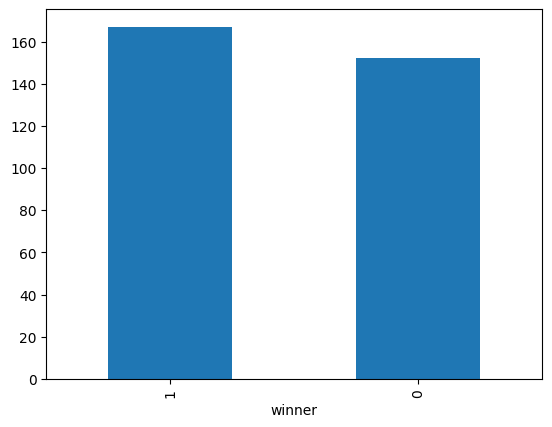

In [ ]:
#Veremos que tan balanceadas estan las clases
games_train["winner"].value_counts().plot(kind="bar")

De primera instancia parecen estar equilibradas, pero lo que nos esta diciendo es que hay un poco más de partidas donde gana el jugador 'A' asi que tendremos que descomponer para ver la distribución de cada jugador

In [ ]:
# Vemos con cuantos jugadores distintos contamos 
import numpy as np

np.union1d(np.unique(games_train["player_A"].values), np.unique(games_train["player_B"].values))


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142])

Parece que tenemos partidas de los 142 jugadores listados, ahora veremos si tenemos al menos una victoria y una derrota por cada jugador 


In [ ]:


def conteos(df, players,busqueda=1):
 
    Victorias_A = 0
    Victorias_B = 0

    for numero in players:
        Victorias_A += ((df['C'] == 1) & (df['A'] == numero)).sum()
        Victorias_B += ((df['C'] == 0) & (df['B'] == numero)).sum()

    resultado_final = conteo_A_cuando_C_es_1 + conteo_B_cuando_C_es_0
    return resultado_final

# Ejemplo de uso:
# Suponiendo que tu DataFrame se llama 'df' y tienes una lista de números a buscar:
# numeros_a_buscar = [1, 2, 3]  # Reemplaza con tus números
# resultado = calcular_conteo_con_array(df, numeros_a_buscar)
# print(resultado)